# Generic HMC 

### Imports

In [1]:
import os
import sys
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from l2hmc_eager import dynamics_eager as _l2hmc
from l2hmc_eager import gauge_dynamics_eager as l2hmc
from l2hmc_eager.neural_nets import *
from utils.distributions import GMM, gen_ring
from utils.jacobian import _map, jacobian
from utils.data_utils import (
    calc_avg_vals_errors, block_resampling, jackknife_err
)

from HMC.hmc import HMC

from lattice.gauge_lattice import GaugeLattice, pbc, mat_adj, u1_plaq_exact

%autoreload 2

Using TensorFlow backend.


In [2]:
from u1_model_eager import *

In [3]:
tf.enable_eager_execution()
tfe = tf.contrib.eager

In [4]:
def train_one_iter(dynamics, x, optimizer, loss_fn=l2hmc.compute_loss, 
                   scale=0.1, eps=1e-4, l2_dist=True, global_step=None):
    loss, grads, out, accept_prob = l2hmc.loss_and_grads(
        dynamics, x, loss_fn=loss_fn, scale=scale, eps=eps, l2_dist=l2_dist
    )
    gradients, _ = tf.clip_by_global_norm(grads, 10.)
    optimizer.apply_gradients(
        zip(grads, dynamics.trainable_variables), global_step=global_step
    )
    return loss, out, accept_prob

In [5]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    result /= result[result.argmax()]
    return result[result.size//2:]

In [6]:
def compute_ac_spectrum(samples_history, target_mean, target_covar):
    """Compute autocorrelation spectrum.
    Follows equation 15 from the L2HMC paper.
    Args:
        samples_history: Numpy array of shape [T, B, D], where T is the total
            number of time steps, B is the batch size, and D is the dimensionality
            of sample space.
        target_mean: 1D Numpy array of the mean of target(true) distribution.
        target_covar: 2D Numpy array representing a symmetric matrix for 
            variance.
    Returns:
        Autocorrelation spectrum, Numpy array of shape [T-1].
    """
    # Using numpy here since eager is a bit slow due to the loop
    time_steps = samples_history.shape[0]
    #trace = np.trace(target_covar)
    trace = 1.
    rhos = []
    for t in range(time_steps - 1):
        rho_t = 0.
        for tau in range(time_steps - t):
            v_tau = samples_history[tau, :] - target_mean
            v_tau_plus_t = samples_history[tau + t, :] - target_mean
            # Take dot product over observation dims and take mean over batch dims
            rho_t = v_tau.T.dot(v_tau_plus_t)
            #rho_t += np.mean(np.sum(v_tau * v_tau_plus_t, axis=1))
        rho_t /= trace * (time_steps - t)
        rhos.append(rho_t)
    return np.array(rhos)


## 2D $U(1)$ Lattice Gauge Theory

### Using L2HMC framework with hmc flag. `hmc=True`

In [11]:
params = {
    'time_size': 8,
    'space_size': 8,
    'link_type': 'U1',
    'dim': 2,
    'beta': 8.,
    'num_samples': 2,
    'num_steps': 10,
    'eps': 0.1,
    'loss_scale': 0.1,
    'loss_eps': 1e-4,
    'learning_rate_init': 1e-4,
    'learning_rate_decay_steps': 100,
    'learning_rate_decay_rate': 0.96,
    'train_steps': 1000,
    'record_loss_every': 50,
    'data_steps': 1,
    'save_steps': 50,
    'print_steps': 1,
    'logging_steps': 5,
    'clip_value': 100,
    'rand': False,
    'metric': 'l2',
    #'conv_net': False,
    #'hmc': True,
}
tf.reset_default_graph()

In [28]:
del model_hmc

In [29]:
model_hmc = GaugeModelEager(params=params,
                            conv_net=False,
                            hmc=True,
                            log_dir=None,
                            restore=False,
                            defun=False,
                            eps_trainable=False)

Creating directory for new run: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_249/
total initialization time: 0.038053274154663086

################################################################################
Model parameters:
log_dir: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_249/

info_dir: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_249/run_info/

figs_dir: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_249/figures/

_defun: False

conv_net: False

hmc: True

time_size: 8

space_size: 8

link_type: U1

dim: 2

beta: 8.0

num_samples: 2

num_steps: 10

eps: 0.1

loss_scale: 0.1

loss_eps: 0.0001

learning_rate_init: 0.0001

learning_rate_decay_steps: 100

learning_rate_decay_rate: 0.96

train_steps: 1000

record_loss_every: 50

data_steps: 1

save_steps: 50

print_steps: 1

logging_steps: 5

clip_value: 100

rand: False

metric: l2

batch_size: 2

################################################################################




In [30]:
observables_hmc = model_hmc.calc_observables(model_hmc.dynamics.samples, 
                                             update=True)
total_actions, avg_plaquettes, top_charges = observables_hmc
helpers.print_run_data(model_hmc.data, header=True)
helpers.write_run_data(model_hmc.files['run_info_file'],  model_hmc.data)

    STEP        LOSS   TIME/STEP  ACCEPT %    EPS      ACTION    TOP Q      PLAQ   
------------------------------------------------------------------------------------
    0/1000       0         0         0        0.1        0         0         1     


In [31]:
_, _, _, samples_out = model_hmc.dynamics.apply_transition(model_hmc.samples)

In [32]:
model_hmc.train(500)

    STEP        LOSS   TIME/STEP  ACCEPT %    EPS      ACTION    TOP Q      PLAQ   
------------------------------------------------------------------------------------
    1/500      -40.48    0.7692    0.3034     0.1      6.989    -0.01881   0.9863  
    2/500      -55.29    0.867     0.3081     0.1      6.989    -0.01881   0.9863  
    3/500      -95.94    0.7718    0.3252     0.1      11.64    0.01805    0.9773  
    4/500      -126.4    0.8096    0.457      0.1      21.67   0.0002614   0.9577  
    5/500      -282.9    0.7955    0.9861     0.1      21.65    -0.03645   0.9577  
    6/500      -230.8    0.7623    0.6583     0.1       29.7    0.03306    0.942   
    7/500      -241.5    0.7552    0.8095     0.1      27.07    0.07956    0.9471  
    8/500      -212.7     1.19     0.6914     0.1       31.9    0.002052   0.9377  
    9/500      -355.9    0.933       1        0.1      28.28    0.04008    0.9448  
   10/500      -323.9    1.079       1        0.1       24.6    0.01987    

   92/500      -206.7    0.7304    0.7205     0.1      26.87    0.04317    0.9475  
   93/500      -166.6    0.7246    0.6637     0.1      32.41    0.02847    0.9367  
   94/500      -283.3    0.7466      1        0.1      28.12    0.03825    0.9451  
   95/500      -186.3    0.7276    0.5893     0.1      28.12    0.03825    0.9451  
   96/500      -186.5    0.7124    0.5749     0.1      31.22    0.01365    0.939   
   97/500      -228.4    0.7206    0.645      0.1      31.62   -0.007802   0.9382  
   98/500      -255.5    0.7401    0.8182     0.1      24.96    0.02443    0.9512  
   99/500      -249.2    0.7122    0.6608     0.1      24.96    0.02443    0.9512  
  100/500      -149.2    0.7329    0.6047     0.1      25.88    0.07187    0.9495  


Saved checkpoint to: /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_249/ckpt-2


    STEP        LOSS   TIME/STEP  ACCEPT %    EPS      ACTION    TOP Q      PLAQ   
-----------------------------------------------------------------------------

  182/500      -203.2    0.7227    0.7088     0.1      37.88    0.007701   0.926   
  183/500       -297     0.7156    0.9228     0.1      35.33    -0.04337   0.931   
  184/500      -216.8    0.7156    0.7429     0.1      35.87    -0.04021   0.9299  
  185/500       -231     0.7226    0.7206     0.1      34.76     -0.03     0.9321  
  186/500       -288     0.6684    0.7901     0.1      35.99    -0.04203   0.9297  
  187/500      -321.5     0.65     0.9755     0.1      38.61    0.001163   0.9246  
  188/500      -200.9    0.6771    0.6799     0.1      36.58    0.02266    0.9286  
  189/500      -275.9    0.667     0.8156     0.1      38.37    0.06629    0.9251  
  190/500      -189.9    0.6813    0.6423     0.1      43.39    -0.01201   0.9153  
  191/500      -287.8    0.6785    0.9427     0.1      43.84    0.01552    0.9144  
  192/500      -329.6    0.6798      1        0.1      38.95    0.01738    0.9239  
  193/500      -318.8    0.6675      1        0.1       32.5    -0.03319   0

  272/500      -250.2    0.7145    0.8771     0.1      34.72    0.02043    0.9322  
  273/500      -302.2    0.6827    0.9507     0.1      30.29    0.02432    0.9408  
  274/500      -276.6    0.6748    0.874      0.1      30.17   -0.005046   0.9411  
  275/500      -307.6    0.685       1        0.1      30.86    -0.04238   0.9397  
  276/500      -171.3    0.6754    0.7546     0.1      29.19    -0.01301   0.943   
  277/500      -268.8    0.6768    0.9007     0.1      28.76   -0.005173   0.9438  
  278/500      -270.7    0.6772    0.8057     0.1      31.97    -0.03944   0.9376  
  279/500      -229.8    0.6744     0.8       0.1      24.45    -0.04983   0.9522  
  280/500      -158.3    0.6973    0.5442     0.1      28.19   -0.001211   0.9449  
  281/500      -277.7    0.6748      1        0.1      27.06    -0.01383   0.9471  
  282/500      -327.4    0.6781      1        0.1      26.14    0.007509   0.949   
  283/500      -272.8    0.6797    0.8268     0.1      24.94    -0.01358   0

  362/500      -184.7    0.6927    0.5991     0.1       40.5    0.02036    0.9209  
  363/500      -257.8    0.6809    0.7161     0.1      41.06    0.06429    0.9198  
  364/500      -272.6    0.6862    0.8153     0.1      42.19    0.04601    0.9176  
  365/500      -392.5    0.6836      1        0.1      38.35    0.02736    0.9251  
  366/500      -193.8    0.6847    0.722      0.1      37.89    0.04884    0.926   
  367/500      -291.5    0.669       1        0.1      35.41    0.03017    0.9308  
  368/500       -275     0.683     0.8262     0.1      33.56    0.01836    0.9345  
  369/500      -355.3    0.6791    0.9419     0.1      33.97    -0.01755   0.9336  
  370/500      -282.9    0.6828    0.8144     0.1      34.69   -0.005942   0.9323  
  371/500      -410.6    0.692       1        0.1      28.43    -0.03833   0.9445  
  372/500      -216.8    0.6872    0.7956     0.1       31.6   -0.005274   0.9383  
  373/500      -241.9    0.6812    0.6875     0.1       38.3    -0.04251   0

  452/500      -294.1    0.6619      1        0.1      32.64    0.06394    0.9363  
  453/500      -340.5    0.6844      1        0.1      32.85   -0.003956   0.9358  
  454/500      -330.7    0.6884      1        0.1      25.52     0.0464    0.9502  
  455/500      -122.6    0.6763    0.4651     0.1      25.52     0.0464    0.9502  
  456/500      -143.9    0.6908    0.4619     0.1      25.52     0.0464    0.9502  
  457/500      -225.1    0.6782    0.7208     0.1      27.85    -0.02038   0.9456  
  458/500      -152.5    0.6865    0.5416     0.1      31.44    0.02219    0.9386  
  459/500      -266.2    0.665     0.9122     0.1      28.34    0.01261    0.9447  
  460/500      -172.9    0.6841    0.6746     0.1      33.55    0.01619    0.9345  
  461/500      -276.4    0.6835    0.7827     0.1      35.75    0.03909    0.9302  
  462/500       -304     0.6674      1        0.1      28.01    0.07006    0.9453  
  463/500       -212     0.702     0.7846     0.1      27.61     0.0504    0

Saving plot to /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_249/figures/average_plaquettes_vs_step.pdf...
Saving plot to /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_249/figures/average_topological_charge_vs_step.pdf...
Saving plot to /Users/saforem2/ANL/l2hmc/gauge_logs_eager/run_249/figures/average_total_action_vs_step.pdf...
done.


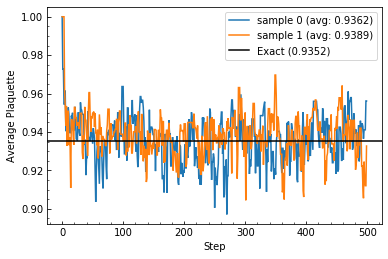

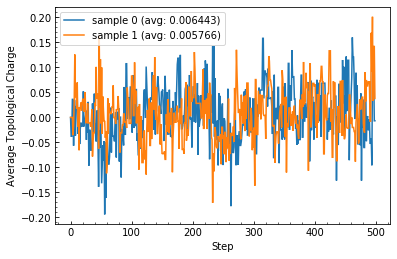

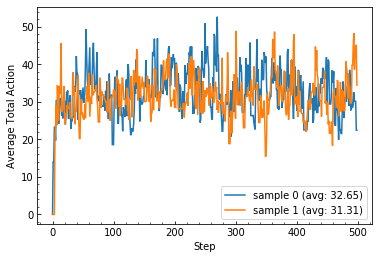

In [34]:
steps_arr = [0]
steps_arr.extend(model_hmc.steps_arr)

_ = helpers.plot_run_data(model_hmc.data, model_hmc.params, steps_arr, 
                          model_hmc.figs_dir, skip_steps=1)

In [36]:
samples_hmc = tf.random_normal(shape=model_hmc.samples.shape)
samples_history_hmc = []
actions_history_hmc = []
avg_plaquettes_history_hmc = []
top_charges_history_hmc = []

In [37]:
for i in range(500):
    #samples_history_hmc.append(samples_hmc.numpy())
    t0 = time.time()
    #_, _, _, samples_hmc = apply_transition_hmc(samples_hmc)
    _, _, _, samples_hmc = model_hmc.dynamics.apply_transition(samples_hmc)
    observables_hmc = np.array(
        model_hmc.lattice.calc_plaq_observables(samples_hmc)
    ).T
    actions_history_hmc.append(observables_hmc[0])
    avg_plaquettes_history_hmc.append(observables_hmc[1])
    top_charges_history_hmc.append(observables_hmc[2])
    step_time = (time.time() - t0) / (model_hmc.num_steps * model_hmc.batch_size)
    print(f'step: {i}  time/step: {step_time:^6.4g} '
          f'top_charge: {np.mean(observables_hmc[2]):^6.4g} '
          f'avg_plaq: {np.mean(observables_hmc[1]):^6.4g}')

step: 0  time/step: 0.3685 top_charge: 0.1002 avg_plaq: 0.4384
step: 1  time/step: 0.4859 top_charge: -0.03979 avg_plaq: 0.6422
step: 2  time/step: 0.5687 top_charge: 0.1123 avg_plaq: 0.7524
step: 3  time/step: 0.5015 top_charge: 0.03645 avg_plaq: 0.8183
step: 4  time/step: 0.4995 top_charge: -0.03705 avg_plaq: 0.8544
step: 5  time/step: 0.4824 top_charge: -0.01861 avg_plaq: 0.8785
step: 6  time/step: 0.4547 top_charge: -0.01154 avg_plaq: 0.8852
step: 7  time/step: 0.3464 top_charge: -0.06579 avg_plaq: 0.8683
step: 8  time/step: 0.2614 top_charge: -0.04183 avg_plaq: 0.8796
step: 9  time/step: 0.266  top_charge: -0.05311 avg_plaq: 0.8974
step: 10  time/step: 0.2645 top_charge: -0.004249 avg_plaq: 0.8929
step: 11  time/step: 0.2571 top_charge: -0.0461 avg_plaq: 0.8961
step: 12  time/step: 0.2623 top_charge: 0.03281 avg_plaq: 0.901 
step: 13  time/step: 0.2537 top_charge: -0.06774 avg_plaq: 0.8958
step: 14  time/step: 0.2617 top_charge: 0.028  avg_plaq: 0.8857
step: 15  time/step: 0.2764 

step: 125  time/step: 0.3532 top_charge: 0.02008 avg_plaq: 0.9394
step: 126  time/step: 0.248  top_charge: -0.03363 avg_plaq: 0.9285
step: 127  time/step: 0.2653 top_charge: 0.005896 avg_plaq: 0.9321
step: 128  time/step: 0.2494 top_charge: -0.04765 avg_plaq: 0.9324
step: 129  time/step: 0.2647 top_charge: -0.03726 avg_plaq: 0.9378
step: 130  time/step: 0.2528 top_charge: 0.006098 avg_plaq: 0.9364
step: 131  time/step: 0.244  top_charge: -0.0247 avg_plaq: 0.9233
step: 132  time/step: 0.2486 top_charge: 0.03184 avg_plaq: 0.9284
step: 133  time/step: 0.2564 top_charge: 0.02464 avg_plaq: 0.9388
step: 134  time/step: 0.2482 top_charge: 0.02464 avg_plaq: 0.9388
step: 135  time/step: 0.2535 top_charge: 0.007148 avg_plaq: 0.9375
step: 136  time/step: 0.3485 top_charge: 0.007148 avg_plaq: 0.9375
step: 137  time/step: 0.327  top_charge: 0.07536 avg_plaq: 0.9286
step: 138  time/step: 0.2802 top_charge: 0.06886 avg_plaq: 0.9294
step: 139  time/step: 0.306  top_charge: 0.03697 avg_plaq: 0.9375
ste

step: 249  time/step: 0.3653 top_charge: 0.0412 avg_plaq: 0.9366
step: 250  time/step: 0.2752 top_charge: 0.05367 avg_plaq: 0.9432
step: 251  time/step: 0.2883 top_charge: 0.05621 avg_plaq: 0.9343
step: 252  time/step: 0.3961 top_charge: 0.0447 avg_plaq: 0.924 
step: 253  time/step: 0.2639 top_charge: 0.02222 avg_plaq: 0.9239
step: 254  time/step: 0.2982 top_charge: 0.01166 avg_plaq: 0.9318
step: 255  time/step: 0.2644 top_charge: 0.06964 avg_plaq: 0.9334
step: 256  time/step: 0.2604 top_charge: -0.03378 avg_plaq: 0.9312
step: 257  time/step: 0.2608 top_charge: -0.01406 avg_plaq: 0.9362
step: 258  time/step: 0.2509 top_charge: -0.04193 avg_plaq: 0.9341
step: 259  time/step: 0.2626 top_charge: -0.03159 avg_plaq: 0.9356
step: 260  time/step: 0.2533 top_charge: -0.03515 avg_plaq: 0.9303
step: 261  time/step: 0.2557 top_charge: 0.06351 avg_plaq: 0.9357
step: 262  time/step:  0.29  top_charge: -0.01158 avg_plaq: 0.9488
step: 263  time/step: 0.2624 top_charge: -0.01158 avg_plaq: 0.9488
step:

step: 372  time/step: 0.2425 top_charge: -0.04755 avg_plaq: 0.9335
step: 373  time/step: 0.235  top_charge: -0.04755 avg_plaq: 0.9335
step: 374  time/step: 0.2521 top_charge: -0.04755 avg_plaq: 0.9335
step: 375  time/step: 0.2463 top_charge: -0.05362 avg_plaq: 0.9233
step: 376  time/step: 0.2503 top_charge: -0.03463 avg_plaq: 0.9361
step: 377  time/step: 0.2336 top_charge: -0.06211 avg_plaq: 0.936 
step: 378  time/step: 0.2393 top_charge: -0.042 avg_plaq: 0.9246
step: 379  time/step: 0.2393 top_charge: -0.01977 avg_plaq: 0.9319
step: 380  time/step: 0.2453 top_charge: -0.02288 avg_plaq: 0.9419
step: 381  time/step: 0.2424 top_charge: -0.01033 avg_plaq: 0.9461
step: 382  time/step: 0.2445 top_charge: -0.02988 avg_plaq: 0.9405
step: 383  time/step: 0.2397 top_charge: -0.0515 avg_plaq: 0.9363
step: 384  time/step: 0.2461 top_charge: 0.01484 avg_plaq: 0.915 
step: 385  time/step: 0.2395 top_charge: -0.028 avg_plaq: 0.919 
step: 386  time/step: 0.2437 top_charge: -0.02478 avg_plaq: 0.9267
s

step: 495  time/step: 0.4844 top_charge: 0.03485 avg_plaq: 0.9133
step: 496  time/step: 0.2957 top_charge: 0.03973 avg_plaq: 0.9158
step: 497  time/step: 0.2765 top_charge: 0.09574 avg_plaq: 0.9105
step: 498  time/step: 0.312  top_charge: 0.08096 avg_plaq: 0.9211
step: 499  time/step: 0.2459 top_charge: 0.07622 avg_plaq: 0.928 


In [39]:
actions_history_hmc = np.array(actions_history_hmc)
avg_plaquettes_history_hmc = np.array(avg_plaquettes_history_hmc)
top_charges_history_hmc = np.array(top_charges_history_hmc)

In [40]:
top_charges_autocorr0_hmc = autocorr(top_charges_history_hmc[:, 0])
top_charges_autocorr1_hmc = autocorr(top_charges_history_hmc[:, 1])

top_charges_autocorr_hmc = (top_charges_autocorr0_hmc 
                            + top_charges_autocorr1_hmc) / 2

In [44]:
%matplotlib notebook

<IPython.core.display.Javascript object>


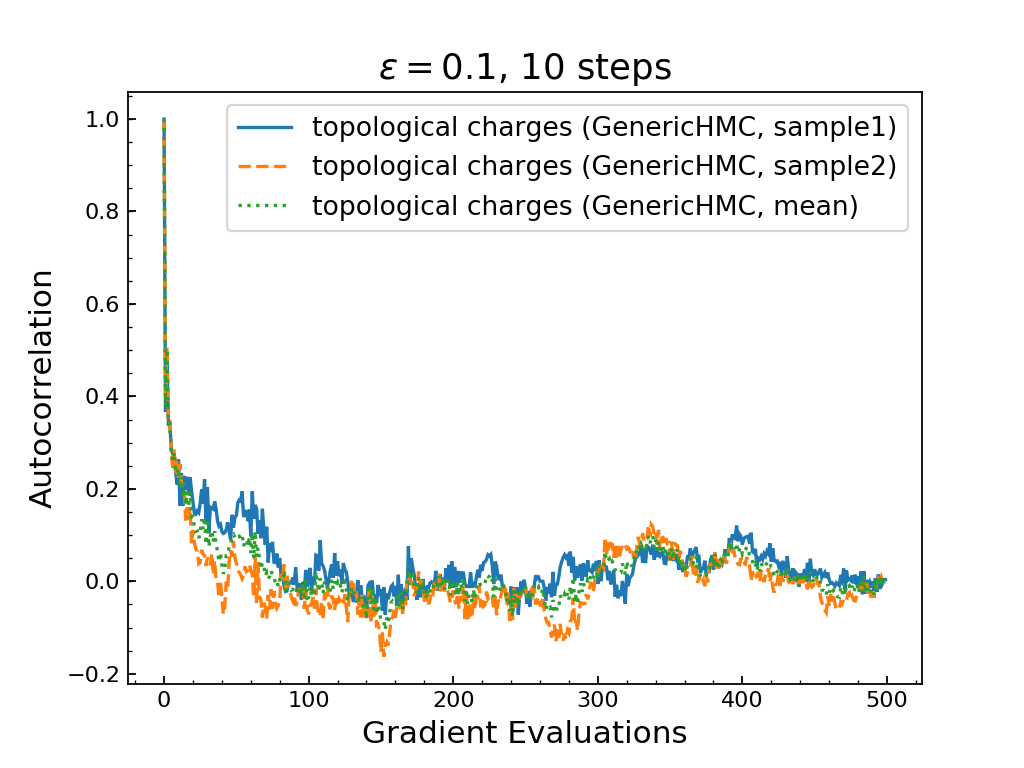

Text(0.5,1,'$\\epsilon = 0.1$, 10 steps')

Text(0,0.5,'Autocorrelation')

Text(0.5,0,'Gradient Evaluations')

In [53]:
steps_hmc = np.arange(len(top_charges_autocorr_hmc))

fig, ax = plt.subplots()
#ax.plot(steps_hmc, top_charges_autocorr_hmc, 
#        marker='', ls='-', label='topological_charge (HMC)')
#ax.plot(steps_hmc, avg_plaquettes_autocorr_hmc,
#        marker='', ls='--', label='avg plaquettes (L2HMC, hmcNet)')
ax.plot(steps_hmc, top_charges_autocorr0_hmc,
        marker='', ls='-', label='topological charges (GenericHMC, sample1)')
ax.plot(steps_hmc, top_charges_autocorr1_hmc,
        marker='', ls='--', label='topological charges (GenericHMC, sample2)')
ax.plot(steps_hmc, top_charges_autocorr_hmc,
        marker='', ls=':', label='topological charges (GenericHMC, mean)')
#ax.plot(steps1, top_charges_autocorr, marker='', ls='-', label='topological_charge (L2HMC)')
ax.set_title(r"$\epsilon = 0.1$, 10 steps", fontsize=16)
ax.set_ylabel('Autocorrelation', fontsize=14)
ax.set_xlabel('Gradient Evaluations', fontsize=14)
ax.legend(loc='best', fontsize=12)
fig.savefig(os.path.join(model_hmc.figs_dir, 
                         'top_charge_autocorrelation_fn_hmc.pdf'), 
            dpi=400, bbox_inches='tight')
#ax.set_xlim((ax.get_xlim()[0], 1000))
#ax.set_xlim((-5, 1000))
plt.show()

### Using HMC.hmc method (separate from L2HMC)

In [54]:
lattice = GaugeLattice(time_size=params['time_size'],
                       space_size=params['space_size'],
                       dim=params['dim'],
                       beta=params['beta'],
                       link_type=params['link_type'],
                       num_samples=params['num_samples'],
                       rand=params['rand'])
#samples = np.array([sample.flatten() for sample in lattice.samples])
lattice_energy_fn = lattice.get_energy_function()

In [55]:
#step_size = params['eps']
step_size = 0.05
#n_leapfrog_steps = params['n_steps']
n_leapfrog_steps = 10
#position_init = samples
position_init = lattice.links.flatten()
lattice_hmc = HMC(position_init=position_init,
                  step_size=step_size,
                  n_leapfrog_steps=n_leapfrog_steps,
                  potential_fn=lattice_energy_fn,
                  beta=lattice.beta)

In [56]:
# 500 steps in ~ 6m 41s
links0 = lattice.links.flatten()
momentum0 = np.random.randn(*links0.shape)
links_arr = [links0]
vel_arr = []
probs_arr = []
total_actions = []
average_plaquettes = []
topological_charges = []
samples_arr = []
links1 = links0
num_steps = 500
print("Exact value of the average plaquette "
      f"(at {params['beta']}): {u1_plaq_exact(params['beta'])}\n")

Exact value of the average plaquette (at 8.0): 0.9352354935294382



In [57]:
for i in range(num_steps):
    t1 = time.time()
    if isinstance(links1, tf.Tensor):
        samples_arr.append(links1.numpy())
    else: 
        samples_arr.append(links1)
    links1, vel1, probs1 = lattice_hmc.apply_transition(links1)
    
    observables = np.array(lattice._calc_plaq_observables(links1))
    _total_actions = observables[0]
    _avg_plaquettes = observables[1]
    _top_charges = observables[2]
    
    total_actions.append(_total_actions)
    average_plaquettes.append(_avg_plaquettes)
    topological_charges.append(_top_charges)
    print(f'\nstep: {i:<5g} accept rate: {np.mean(probs1):^8.5g}  '
      f' time/step: {(time.time() - t1) / n_leapfrog_steps:^6.4g} '
      f' avg_S: {np.mean(_total_actions):^8.5g} '
      f' avg_topQ: {np.mean(_top_charges):^8.5g} '
      f' avg_plaq: {np.mean(_avg_plaquettes):^8.5g}\n ')


step: 0     accept rate: 0.88427    time/step: 3.386   avg_S:    0      avg_topQ:    0      avg_plaq:    1    
 

step: 1     accept rate: 0.87588    time/step:  3.07   avg_S:  8.1681   avg_topQ: -0.011522  avg_plaq: 0.98405 
 

step: 2     accept rate: 0.79213    time/step: 4.222   avg_S:  22.236   avg_topQ: 0.007084  avg_plaq: 0.95657 
 

step: 3     accept rate: 0.91126    time/step: 2.718   avg_S:  24.423   avg_topQ: -0.0034203  avg_plaq:  0.9523 
 

step: 4     accept rate:    1       time/step: 2.116   avg_S:  22.827   avg_topQ: 0.0015373  avg_plaq: 0.95542 
 

step: 5     accept rate: 0.97234    time/step:  1.37   avg_S:  23.07    avg_topQ: -0.01809  avg_plaq: 0.95494 
 

step: 6     accept rate: 0.97881    time/step:  1.5    avg_S:  24.037   avg_topQ: 0.067942  avg_plaq: 0.95305 
 

step: 7     accept rate:    1       time/step: 1.381   avg_S:  21.428   avg_topQ: -0.028785  avg_plaq: 0.95815 
 

step: 8     accept rate: 0.97813    time/step: 1.494   avg_S:  21.365   avg_topQ: 


step: 72    accept rate: 0.92488    time/step: 2.227   avg_S:  34.936   avg_topQ: -0.015032  avg_plaq: 0.93177 
 

step: 73    accept rate: 0.89242    time/step: 2.046   avg_S:  40.803   avg_topQ: 0.0085775  avg_plaq: 0.92031 
 

step: 74    accept rate:    1       time/step: 2.035   avg_S:  39.396   avg_topQ: -0.11271  avg_plaq: 0.92306 
 

step: 75    accept rate:    1       time/step: 2.126   avg_S:  30.373   avg_topQ: 0.057922  avg_plaq: 0.94068 
 

step: 76    accept rate: 0.89127    time/step: 2.051   avg_S:  34.004   avg_topQ: -0.059836  avg_plaq: 0.93359 
 

step: 77    accept rate: 0.91741    time/step: 2.163   avg_S:  40.041   avg_topQ: 0.039858  avg_plaq: 0.92179 
 

step: 78    accept rate: 0.86857    time/step: 3.265   avg_S:  48.554   avg_topQ: -0.0098587  avg_plaq: 0.90517 
 

step: 79    accept rate:    1       time/step: 2.833   avg_S:  45.628   avg_topQ: 0.016263  avg_plaq: 0.91088 
 

step: 80    accept rate:    1       time/step: 3.979   avg_S:  38.939   avg_topQ: 


step: 144   accept rate:    1       time/step: 2.453   avg_S:  33.051   avg_topQ: -0.075152  avg_plaq: 0.93545 
 

step: 145   accept rate:    1       time/step: 1.972   avg_S:  28.673   avg_topQ: 0.034367  avg_plaq:  0.944  
 

step: 146   accept rate:    1       time/step: 2.098   avg_S:  29.31    avg_topQ: 0.02593   avg_plaq: 0.94275 
 

step: 147   accept rate:    1       time/step: 2.249   avg_S:  28.315   avg_topQ: 0.037224  avg_plaq:  0.9447 
 

step: 148   accept rate:    1       time/step: 1.856   avg_S:  19.684   avg_topQ: -0.054174  avg_plaq: 0.96155 
 

step: 149   accept rate:  0.9481    time/step: 2.076   avg_S:  23.089   avg_topQ: 0.039728  avg_plaq:  0.9549 
 

step: 150   accept rate: 0.91275    time/step: 2.294   avg_S:  28.246   avg_topQ: -0.032347  avg_plaq: 0.94483 
 

step: 151   accept rate: 0.95216    time/step:  2.17   avg_S:  29.778   avg_topQ: 0.021676  avg_plaq: 0.94184 
 

step: 152   accept rate: 0.95303    time/step: 2.433   avg_S:  35.719   avg_topQ: -0


step: 216   accept rate:    1       time/step: 1.909   avg_S:  29.322   avg_topQ: 0.036647  avg_plaq: 0.94273 
 

step: 217   accept rate:    1       time/step: 1.894   avg_S:  25.788   avg_topQ: 0.014935  avg_plaq: 0.94963 
 

step: 218   accept rate:    1       time/step: 1.926   avg_S:  27.45    avg_topQ: -0.031948  avg_plaq: 0.94639 
 

step: 219   accept rate:    1       time/step: 1.928   avg_S:  26.069   avg_topQ: 0.040381  avg_plaq: 0.94908 
 

step: 220   accept rate: 0.89859    time/step: 1.977   avg_S:  35.443   avg_topQ: 0.015009  avg_plaq: 0.93078 
 

step: 221   accept rate:    1       time/step: 1.999   avg_S:  33.89    avg_topQ: 0.037159  avg_plaq: 0.93381 
 

step: 222   accept rate:    1       time/step: 2.099   avg_S:  26.495   avg_topQ: -0.022245  avg_plaq: 0.94825 
 

step: 223   accept rate:  0.9665    time/step: 1.936   avg_S:  28.178   avg_topQ: 0.091614  avg_plaq: 0.94496 
 

step: 224   accept rate: 0.88291    time/step: 1.902   avg_S:  35.789   avg_topQ: -0.


step: 288   accept rate:    1       time/step: 1.896   avg_S:  34.683   avg_topQ: -0.023707  avg_plaq: 0.93226 
 

step: 289   accept rate:    1       time/step: 1.929   avg_S:  34.981   avg_topQ: 0.033986  avg_plaq: 0.93168 
 

step: 290   accept rate:    1       time/step:  2.23   avg_S:  35.872   avg_topQ: -0.056514  avg_plaq: 0.92994 
 

step: 291   accept rate:    1       time/step: 2.088   avg_S:  33.105   avg_topQ: 0.0035559  avg_plaq: 0.93534 
 

step: 292   accept rate:    1       time/step: 2.344   avg_S:  29.357   avg_topQ: -0.070123  avg_plaq: 0.94266 
 

step: 293   accept rate:    1       time/step: 2.046   avg_S:  27.636   avg_topQ: 0.040836  avg_plaq: 0.94602 
 

step: 294   accept rate:  0.995     time/step: 2.103   avg_S:  28.55    avg_topQ: -0.026405  avg_plaq: 0.94424 
 

step: 295   accept rate: 0.90885    time/step: 2.076   avg_S:  30.331   avg_topQ: 0.0037915  avg_plaq: 0.94076 
 

step: 296   accept rate: 0.95615    time/step: 2.669   avg_S:  35.426   avg_topQ:


step: 360   accept rate:    1       time/step: 1.918   avg_S:  31.731   avg_topQ: 0.029288  avg_plaq: 0.93803 
 

step: 361   accept rate:    1       time/step: 1.904   avg_S:  31.797   avg_topQ: -0.057073  avg_plaq:  0.9379 
 

step: 362   accept rate: 0.97686    time/step: 1.951   avg_S:  34.112   avg_topQ: 0.039293  avg_plaq: 0.93338 
 

step: 363   accept rate:    1       time/step: 1.913   avg_S:  34.399   avg_topQ: -0.062509  avg_plaq: 0.93282 
 

step: 364   accept rate:    1       time/step: 2.016   avg_S:  34.457   avg_topQ: 0.061616  avg_plaq:  0.9327 
 

step: 365   accept rate: 0.98496    time/step: 2.389   avg_S:  33.877   avg_topQ: -0.079848  avg_plaq: 0.93383 
 

step: 366   accept rate: 0.98177    time/step: 2.018   avg_S:  34.257   avg_topQ: -0.0020441  avg_plaq: 0.93309 
 

step: 367   accept rate:  0.8809    time/step: 2.133   avg_S:  40.042   avg_topQ: 0.0061143  avg_plaq: 0.92179 
 

step: 368   accept rate:    1       time/step: 2.431   avg_S:  32.132   avg_topQ:


step: 432   accept rate:    1       time/step: 2.759   avg_S:  23.19    avg_topQ: -0.045857  avg_plaq: 0.95471 
 

step: 433   accept rate:    1       time/step: 2.331   avg_S:  27.691   avg_topQ: 0.070071  avg_plaq: 0.94592 
 

step: 434   accept rate:    1       time/step: 2.439   avg_S:  22.609   avg_topQ: -0.075854  avg_plaq: 0.95584 
 

step: 435   accept rate: 0.96009    time/step: 2.868   avg_S:  24.088   avg_topQ: 0.029677  avg_plaq: 0.95295 
 

step: 436   accept rate: 0.93827    time/step: 2.988   avg_S:  29.475   avg_topQ: -0.027745  avg_plaq: 0.94243 
 

step: 437   accept rate: 0.96531    time/step: 2.625   avg_S:  32.318   avg_topQ: -0.015832  avg_plaq: 0.93688 
 

step: 438   accept rate:    1       time/step: 1.661   avg_S:  30.655   avg_topQ: -0.032423  avg_plaq: 0.94013 
 

step: 439   accept rate:    1       time/step: 1.591   avg_S:  25.991   avg_topQ: 0.024185  avg_plaq: 0.94924 
 

step: 440   accept rate: 0.96643    time/step: 1.797   avg_S:  27.139   avg_topQ: 

In [62]:
total_actions = np.array(total_actions)
average_plaquettes = np.array(average_plaquettes)
topological_charges = np.array(topological_charges)
samples_arr = np.array(samples_arr)
print(total_actions.shape, average_plaquettes.shape, topological_charges.shape)

(500,) (500,) (500,)


In [63]:
topological_charges_autocorr = autocorr(topological_charges)

In [67]:
topological_charges_autocorr

array([ 1.00000000e+00, -6.51730597e-01,  6.12195730e-01, -4.47339058e-01,
        4.41719592e-01, -3.85232985e-01,  3.43926311e-01, -3.27519655e-01,
        3.05988461e-01, -2.97644943e-01,  2.90270060e-01, -2.78267503e-01,
        2.91169584e-01, -2.43366584e-01,  2.50272661e-01, -2.23220378e-01,
        2.21890062e-01, -2.01363757e-01,  1.67079493e-01, -1.56301200e-01,
        1.49861783e-01, -1.58626199e-01,  1.30406410e-01, -1.22126453e-01,
        1.15530729e-01, -1.01637624e-01,  5.65992333e-02, -6.79948926e-02,
        4.97984961e-02, -3.32203060e-02,  8.68806383e-04,  2.44501363e-02,
       -5.07316105e-02,  7.32021928e-02, -8.37779120e-02,  5.82050011e-02,
       -6.63853511e-02,  2.77339164e-02, -4.93428186e-02,  9.00520105e-03,
        4.76780813e-03, -2.06984580e-02,  2.00562403e-02, -2.61659902e-02,
       -1.16634518e-02,  2.06064787e-02, -7.73346871e-02,  2.46277992e-02,
       -5.96451312e-02,  1.07643171e-03, -3.10844872e-02, -2.77156625e-02,
        2.42430773e-02, -

<IPython.core.display.Javascript object>


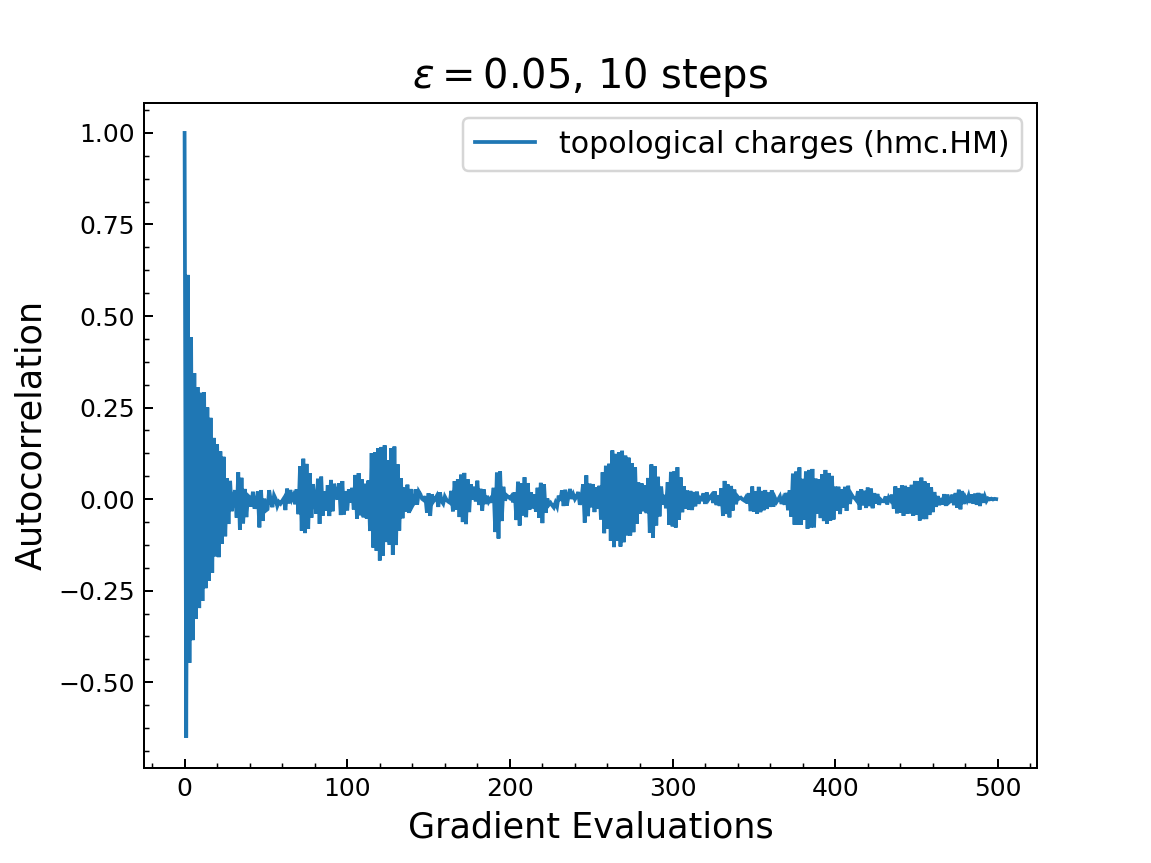

Text(0.5,1,'$\\epsilon = 0.05$, 10 steps')

Text(0,0.5,'Autocorrelation')

Text(0.5,0,'Gradient Evaluations')

In [66]:
steps_hmc = np.arange(len(topological_charges_autocorr))

fig, ax = plt.subplots()
ax.plot(steps_hmc, topological_charges_autocorr,
        marker='', ls='-', label='topological charges (hmc.HMC)')
ax.set_title(r"$\epsilon = 0.05$, 10 steps", fontsize=16)
ax.set_ylabel('Autocorrelation', fontsize=14)
ax.set_xlabel('Gradient Evaluations', fontsize=14)
ax.legend(loc='best', fontsize=12)
#fig.savefig(os.path.join(model_hmc.figs_dir, 
#                         'top_charge_autocorrelation_fn_hmc.pdf'), 
#            dpi=400, bbox_inches='tight')
plt.show()

In [70]:
target_mean = np.mean(samples_arr, axis=0)

In [71]:
samples_autocorr = compute_ac_spectrum(samples_arr, target_mean=target_mean,
                                       target_covar=None)

<IPython.core.display.Javascript object>


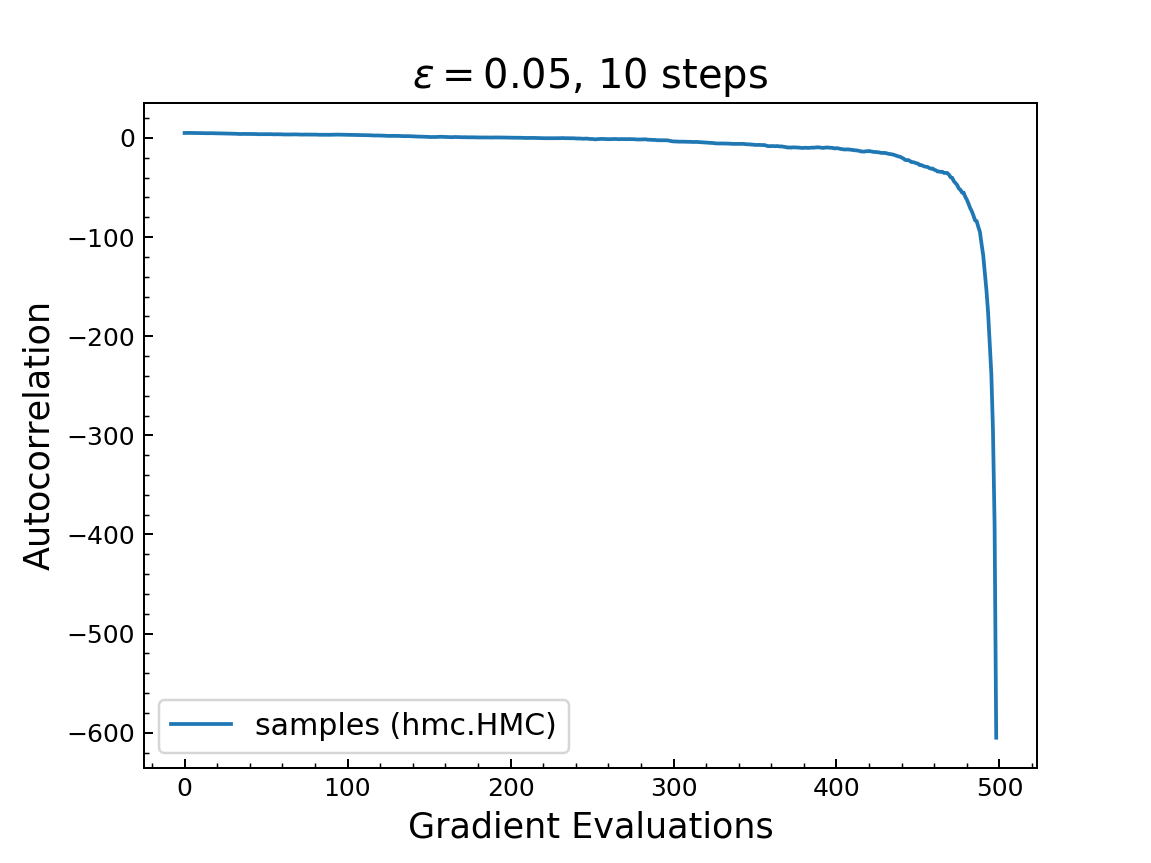

Text(0.5,1,'$\\epsilon = 0.05$, 10 steps')

Text(0,0.5,'Autocorrelation')

Text(0.5,0,'Gradient Evaluations')

In [72]:
steps_hmc = np.arange(len(samples_autocorr))

fig, ax = plt.subplots()
ax.plot(steps_hmc, samples_autocorr,
        marker='', ls='-', label='samples (hmc.HMC)')
ax.set_title(r"$\epsilon = 0.05$, 10 steps", fontsize=16)
ax.set_ylabel('Autocorrelation', fontsize=14)
ax.set_xlabel('Gradient Evaluations', fontsize=14)
ax.legend(loc='best', fontsize=12)
#fig.savefig(os.path.join(model_hmc.figs_dir, 
#                         'top_charge_autocorrelation_fn_hmc.pdf'), 
#            dpi=400, bbox_inches='tight')
plt.show()

In [61]:
apply_transition = tfe.defun(lattice_hmc.apply_transition)

In [ ]:
_samples = tf.random_normal(shape=links1.shape)
#_samples = np.random.randn(*links1.shape)
samples_arr = []
actions_arr = []
plaquettes_arr = []
top_charges_arr = []
for i in range(500):
    samples_arr.append(_samples)
    _samples, _, _ = apply_transition(_samples)
    
    observables = np.array(lattice._calc_plaq_observables(_samples))
    _total_actions = observables[0]
    _avg_plaquettes = observables[1]
    _top_charges = observables[2]
    
    actions_arr.append(_total_actions)
    plaquettes_arr.append(_avg_plaquettes)
    top_charges_arr.append(_top_charges)

In [ ]:

#apply_transition = tfe.defun(lattice_hmc.apply_transition)

#_samples = tf.random_normal(shape=links1.shape)
#_samples = np.random.randn(*links1.shape)
#samples_arr = []
#actions_arr = []
#plaquettes_arr = []
#top_charges_arr = []
#for i in range(100):
    #samples_arr.append(_samples)
    #_samples, _, _ = apply_transition(_samples)
    #
    #observables = np.array(lattice._calc_plaq_observables(_samples))
    #_total_actions = observables[0]
    #_avg_plaquettes = observables[1]
    #_top_charges = observables[2]
    #
    #actions_arr.append(_total_actions)
    #plaquettes_arr.append(_avg_plaquettes)
    #top_charges_arr.append(_top_charges)

In [ ]:
samples_arr[0]

In [ ]:
samples_arr[-1]

In [ ]:
_samples_arr = [samples_arr[0]]

In [ ]:
type(samples_arr[1])

In [ ]:
isinstance(samples_arr[1], tf.Tensor)

In [ ]:
samples_arr[2].numpy()

In [ ]:
_samples_arr.append([i.numpy() for i in samples_arr if isinstance(i, tf.Tensor)])

In [ ]:
_samples_arr = np.array(_samples_arr)
_samples_arr.shape

In [ ]:
samples_arr = np.array([sample.numpy() for sample in samples_arr])
samples_arr.shape

In [ ]:
samples_arr[1]

In [ ]:
samples_autocorr = autocorr(samples_arr)

In [ ]:
top_charge_autocorr4 = autocorr(np.array(topological_charges))
steps = np.arange(len(top_charge_autocorr))

In [ ]:
top_charge_autocorr3 = autocorr(np.array(topological_charges))
steps = np.arange(len(top_charge_autocorr))

In [ ]:
top_charge_autocorr2 = autocorr(np.array(topological_charges))
steps = np.arange(len(top_charge_autocorr))

In [ ]:
top_charge_autocorr1 = autocorr(np.array(topological_charges))
steps = np.arange(len(top_charge_autocorr))

In [ ]:
top_charge_autocorr = autocorr(np.array(topological_charges))
steps = np.arange(len(top_charge_autocorr))

In [ ]:
samples_autocorr = autocorr(np.array())

## Create plots

In [ ]:
%matplotlib notebook

In [ ]:
steps = np.arange(len(top_charge_autocorr))
fig, ax = plt.subplots()
ax.plot(steps, top_charge_autocorr, ls='-', marker='', 
        label=f"HMC (eps: {params['eps']}, 5 steps)")
ax.plot(steps, top_charge_autocorr1, ls='-', marker='', 
        label=f"HMC (eps: {0.1}, 5 steps)")
ax.plot(steps, top_charge_autocorr2, ls='-', marker='', 
        label=f"HMC (eps: {0.025}, 5 steps)")
ax.plot(steps, top_charge_autocorr, ls='-', marker='', 
        label=f"HMC (eps: {0.05}, 10 steps)")
ax.plot(steps, top_charge_autocorr4, ls='-', marker='', 
        label=f"HMC (eps: {0.025}, 10 steps)")
ax.set_xlabel('Gradient computations')
ax.set_ylabel('Autocorrelation of Topological Charge')
#ax.set_xlim((-2, 50))
ax.legend(loc='best')
fig.savefig(
    '../../figures/HMC_autocorrelation_fn/top_charge_autocorr_no_l2hmc.pdf', 
    dpi=400, bbox_inches='tight'
)
plt.show()

In [ ]:
steps = np.arange(len(samples_autocorr))
fig, ax = plt.subplots()
ax.semilogy(steps, samples_autocorr, ls='-', marker='', 
        label=f"HMC (eps: {params['eps']}, 5 steps)")
ax.set_xlabel('Gradient computations')
ax.set_ylabel('Autocorrelation from Samples')
#ax.set_xlim((-2, 50))
ax.legend(loc='best')
#fig.savefig(
#    '../../figures/HMC_autocorrelation_fn/top_charge_autocorr_no_l2hmc.pdf', 
#    dpi=400, bbox_inches='tight'
#)
plt.show()

In [ ]:
np.mean(average_plaquettes)

In [ ]:
print(u1_plaq_exact(beta))

## Using L2HMC with auxiliary functions $Q, S, T \equiv 0$ (i.e. generic HMC)

In [ ]:
##########################  Parameters  #####################################
# n_steps: number of leapfrog steps, eps: initial step size for dynamics
# loss_scale: scaling factor (lambda^2 in paper) in loss objective
# loss_eps: for numeric stability in loss function
# beta: inverse coupling strength
##############################################################################
time_size, space_size, dim, beta, num_samples = (4, 4, 2, 3., 4)
n_steps, eps, loss_scale, loss_eps = (10, 0.1, .1, 1e-4)
rand=True
l2_dist = True
conv_net = True

In [ ]:
u1_lattice = GaugeLattice(time_size, space_size, dim, beta,
                          link_type='U1', num_samples=num_samples, rand=rand)
if conv_net:
    u1_samples_tensor = tf.convert_to_tensor(u1_lattice.samples, 
                                             dtype=tf.float32)
else:
    flat_samples = [sample.flatten() for sample in u1_lattice.samples]
    u1_samples_tensor = tf.convert_to_tensor(np.stack(flat_samples), 
                                             dtype=tf.float32)

# Construct dynamics object
u1_energy_fn = u1_lattice.get_energy_function(u1_samples_tensor)
u1_dynamics = l2hmc.GaugeDynamics(u1_lattice, n_steps=n_steps, eps=eps,
                                  minus_loglikelihood_fn=u1_energy_fn, 
                                  conv_net=conv_net, test_HMC=True)

In [ ]:
global_step = tf.train.get_or_create_global_step()
_ = global_step.assign(1)
train_iters = 500
record_loss_every = 50
save_steps = 50 

learning_rate = tf.train.exponential_decay(1e-2, global_step, 50,
                                           0.96, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate)
checkpointer = tf.train.Checkpoint(
    optimizer=optimizer, dynamics=u1_dynamics, global_step=global_step
)
#summary_writer = tf.contrib.summary.create_file_writer(log_dir)
loss_fn = l2hmc.compute_loss

print(u1_plaq_exact(beta))

In [ ]:
#################    Run L2HMC algorithm    ##################################
total_actions = []
average_plaquettes = []
topological_charges = []
samples = u1_samples_tensor

In [ ]:
t0 = time.time()
start_step = global_step.numpy()
for i in range(start_step, 1000):
    t1 = time.time()
    loss, samples, accept_prob = train_one_iter(
        u1_dynamics,
        samples,
        optimizer,
        loss_fn=loss_fn,
        scale=loss_scale,
        eps=loss_eps,
        global_step=global_step
    )
    observables = np.array(u1_lattice.calc_plaq_observables(samples))
    _total_actions = observables[:, 0]
    _avg_plaquettes = observables[:, 1]
    _top_charges = observables[:, 2]
    
    total_actions.append(_total_actions)
    average_plaquettes.append(_avg_plaquettes)
    topological_charges.append(_top_charges)
    
    print(f'\nstep: {i:<5g} loss: {loss.numpy():^8.5g} '
          f' time/step: {time.time() - t1:^6.4g} '
          f' accept: {accept_prob.numpy().mean():^8.5g} '
          f' eps: {u1_dynamics.eps.numpy():^6.4g} '
          f' avg_S: {np.mean(_total_actions):^8.5g} '
          f' avg_topQ: {np.mean(_top_charges):^8.5g} '
          f' avg_plaq: {np.mean(_avg_plaquettes):^8.5g}\n ')
    print('avg_plaquettes: {}\n'.format([_avg_plaquettes]))

In [ ]:
samples = u1_samples_tensor
print(samples.shape)

In [ ]:
x = tf.reshape(samples, shape=[samples.shape[0], -1])
y = tf.random_normal(x.shape)

In [ ]:
xy = tf.matmul(x, y, transpose_b=True)

In [ ]:
xy_loss = tf.reduce_sum(xy / (tf.norm(x) * tf.norm(y)), axis=1)

In [ ]:
loss = tf.reduce_mean((loss_scale / xy_loss - xy_loss / loss_scale), axis=0)

In [ ]:
loss

In [ ]:
help(tf.clip_by_global_norm)

In [ ]:
tf.abs

In [ ]:
ss = tf.matmul(samples, samples)
print(ss.shape)

In [ ]:
avg_plaqs_arr = np.array(average_plaquettes)
_avg_plaqs_arr = np.mean(avg_plaqs_arr, axis=0)
avg_plaq, avg_plaq_err = calc_avg_vals_errors(avg_plaqs_arr[450:500], num_blocks=50)
print(f'avg_plaq (mean from arr): {np.mean(_avg_plaqs_arr)}')
print(f'avg_plaq: {avg_plaq} +/- {avg_plaq_err}')

In [ ]:
np.mean(average_plaquettes[-100:])

In [ ]:
def project_angle(x):
    """Function to project an angle from [-4pi, 4pi] to [-pi, pi]."""
    return x - 2 * np.pi * tf.math.floor((x + np.pi) / (2 * np.pi))

In [ ]:
project_angle(-2 * np.pi)

In [ ]:
t = np.arange(-10, 10, 0.05)
y = project_angle(t)

In [ ]:
fig, ax = plt.subplots()
ax.plot(t, y, 'o')

## Strongly Correlated Gaussian target distribution (for testing HMC implementation)

### Define log density function of target distribution (potential energy function) $S(x)$

$$ S(\mathbf{x}) = \frac{-\frac{1}{2} (\mathbf{x} - \mathbf{\mu})^{T} \mathbf{\Sigma}^{-1}(\mathbf{x} - \mathbf{\mu})}{\sqrt{|\Sigma|}} $$ 


In [ ]:
mu = np.zeros(2)
cov = np.array([[1., 0.95], [0.95, 1.]], dtype=np.float32)
cov_inv = np.linalg.inv(np.copy(cov))
def quadratic_gaussian(x):
    x_mu = x - mu
    return 0.5 * tf.reduce_sum(tf.transpose(x_mu) * cov_inv * x_mu)

def quadratic_gaussian_grad(x):
    return x

### Exact target distribution

In [ ]:
mean = [0, 0]
cov = [[1., 0.95], [0.95, 1.]]
samples_x, samples_y = np.random.multivariate_normal(mean, cov, 1000).T

### Instantiate HMC object for sampling

In [ ]:
step_size = 0.1
n_leapfrog_steps = 15
hmc = HMC(position_init=np.random.randn(2), 
          step_size=step_size,
          n_leapfrog_steps=n_leapfrog_steps,
          potential_fn=quadratic_gaussian,
          grad_potential_fn=grad_quad_gaussian)
          #grad_potential_fn=grad_quad_gaussian)

In [ ]:
pos0 = [[-1., 1.]]
pos = [pos0]
vel = []
probs = []
pos1 = pos0

for i in range(500):
    #pos0 = pos[i-1]
    pos1, vel1, probs1 = hmc.apply_transition(pos1)
    pos.append(pos1)
    vel.append(vel1)
    probs.append(probs1)
pos = np.array(pos).reshape(len(pos), -1)
vel = np.array(vel)
probs = np.array(probs)

In [ ]:
fig, ax = plt.subplots()
_ = ax.plot(samples_x, samples_y, marker='o', ls='', alpha=0.45)
_ = ax.plot(pos[:,0], pos[:,1], marker='o', ls='', alpha=0.6)
_ = ax.set_title('500 transitions, numerical gradient')
plt.show()

### Look at the leapfrog integrator to tune hyperparameters

In [ ]:
x0 = np.array([-1., 1.])
p0 = np.random.randn(*np.array(x0).shape)
x, p = x0, p0
x_arr = []
p_arr = []
for i in range(n_leapfrog_steps):
    lf_out = hmc._leapfrog_fn(x, p, i)
    x, p = lf_out
    x_arr.append(x)
    p_arr.append(p)
x_arr = np.array(x_arr)
p_arr = np.array(p_arr)

In [ ]:
fig, ax = plt.subplots()
_ = ax.plot(samples_x, samples_y, marker='o', ls='', alpha=0.45)
_ = ax.plot(x_arr[:,0], x_arr[:,1], marker='.', ls='-', alpha=0.6)
plt.show()

In [ ]:
fig, ax = plt.subplots()
_ = ax.plot(samples_x, samples_y, marker='o', ls='', alpha=0.45)
_ = ax.plot(pos[:,0], pos[:,1], marker='o', ls='', alpha=0.6)
_ = ax.set_title('500 transitions, numerical gradient')
plt.show()